In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2249.998
cache size	: 512 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 spec_store_bypass retbleed
bogomips	: 4499.99
TLB s

In [ ]:
!pip install 'umap-learn==0.3.10'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.3.10-py3-none-any.whl size=38880 sha256=b8a41d835c0ca2b9857baff348b630176f965a6265e6198c47be1d5a8c5dd39e
  Stored in directory: /root/.cache/pip/wheels/d8/5b/bb/addda229a9f418417d287055c1daf4acf4c6b074e2d38dfcfa
Successfully built umap-learn


In [ ]:
import umap

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
validation_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_validation_data.csv.xz")
#
# numer of features excluding target
X_train= training_data.drop(['id','era','data_type','target'],axis=1)
y_train=training_data['target']

X_val = validation_data.drop(['id','era','data_type','target'],axis=1)
y_val = validation_data['target']

print("number of features {}".format(len(training_data.columns)-4))
#print("ratio of val to train {}".format(len(y_val)/len(y_train)))

number of features 310


In [ ]:
from pandas.core.groupby.generic import DataFrameGroupBy
from sklearn.preprocessing import MinMaxScaler
def get_group_stats(df: pd.DataFrame) -> pd.DataFrame:
        for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
            cols = [col for col in df.columns if group in col]
            df[f"feature_{group}_mean"] = df[cols].mean(axis=1)
            df[f"feature_{group}_std"] = df[cols].std(axis=1)
            df[f"feature_{group}_skew"] = df[cols].skew(axis=1)
        return df

def min_max_stats(df: pd.DataFrame) -> pd.DataFrame:
        mini=MinMaxScaler()
        for group in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]:
            df[f"feature_{group}_mean"] = mini.fit_transform(df[f"feature_{group}_mean"].values.reshape(-1,1))
            df[f"feature_{group}_std"] = mini.fit_transform(df[f"feature_{group}_std"].values.reshape(-1,1))
            df[f"feature_{group}_skew"] = mini.fit_transform(df[f"feature_{group}_skew"].values.reshape(-1,1))
        return df 

train=get_group_stats(X_train)
val=get_group_stats(X_val)

trainm= min_max_stats(train)
valm=min_max_stats(val)

In [ ]:
sd = train.std().sort_values(ascending = False)
sd

feature_intelligence1        0.353596
feature_intelligence4        0.353596
feature_wisdom29             0.353596
feature_charisma83           0.353596
feature_wisdom20             0.353596
                               ...   
feature_constitution_std     0.093975
feature_wisdom_skew          0.056404
feature_charisma_skew        0.056295
feature_strength_skew        0.048776
feature_constitution_skew    0.043498
Length: 328, dtype: float64

In [ ]:
highsdcol=sd[sd > 0.345].index

In [ ]:
train2=trainm[highsdcol]
val2=valm[highsdcol]

In [ ]:
u=umap.UMAP()
trainumap=u.fit_transform(trainm.values)
#valumap=umap.UMAP().fit_transform(valm.values)

#trainsdumap,=umap.UMAP().fit_transform(train2.values)
#valsdumap = umap.UMAP().fit_transform(val2.values)

NameError: ignored

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

In [ ]:

grid2 = {
   
   # "min_samples_split": np.arange(4,7),
   # "min_samples_leaf":np.arange(1,4),
      "max_depth": np.arange(3,8,1),
    "learning_rate": np.arange(0.0002,0.01,0.0002),
    #"max_leaf_nodes":np.arange(2,4,2)

}
 
#dict3={'learning_rate': 0.009600000000000001, 'max_depth': 4, 'max_leaf_nodes': 2}

gbr=GradientBoostingRegressor()

gcv=GridSearchCV(estimator=gbr,param_grid=grid2,cv=3)

gcv.fit(train2,y_train)

result4=gcv.predict(train2)

In [ ]:
from sklearn.ensemble import StackingRegressor,GradientBoostingRegressor,RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

esti=[('gradientboostingregressor',GradientBoostingRegressor())]
sv=StackingRegressor(estimators=esti,final_estimator=RandomForestRegressor()) 
namenot = ["gradientboostingregressor__","final_estimator__"]

svgrid= {
    #namenot[0]+"min_samples_split": np.arange(4,7),
  #  namenot[0]+"min_samples_leaf":np.arange(1,4),
    #  namenot[0]+"max_depth": np.arange(3,5,1),e
   # namenot[0]+"learning_rate": np.arange(0.0002,0.01,0.0002),
  #  namenot[0]+"max_leaf_nodes":np.arange(2,4,2), b 
 #  namenot[1]+ "max_features": ['sqrt', 'log2', 0.1], 
 #   namenot[1]+"min_samples_split": np.arange(4,7),
 #   namenot[1]+"min_samples_leaf":np.arange(1,4),
   #   namenot[1]+"max_depth": np.arange(5,20,5),
  
    #namenot[1]+"max_leaf_nodes":np.arange(2,4,2)
}

#gsv = GridSearchCV(estimator=sv,param_grid=svgrid,cv= 3 )

sv.fit(train2,y_train )



StackingRegressor(estimators=[('gradientboostingregressor',
                               GradientBoostingRegressor())],
                  final_estimator=RandomForestRegressor())

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
grid_1 = {
    'learning_rate': [0.03, 0.01, 0.03, 0.009],
    'bootstrap_type':['Bayesian'],
    'bagging_temperature': [0, 1, 10]
}
#grid_2 = {
##    'learning_rate': [0.03, 0.01, 0.003, 0.009],
 ##   'bootstrap_type':['Bernoulli'], 
#    'subsample': [0.8, 0.87, 0.92]
#}
catjawn=CatBoostRegressor()
grid_search_results = catjawn.grid_search([grid_1], train2,y_train)

Streaming output truncated to the last 5000 lines.
26:	learn: 0.3131625	test: 0.3136064	best: 0.3136064 (26)	total: 4.09s	remaining: 2m 27s
27:	learn: 0.3085719	test: 0.3090225	best: 0.3090225 (27)	total: 4.26s	remaining: 2m 28s
28:	learn: 0.3041894	test: 0.3046468	best: 0.3046468 (28)	total: 4.41s	remaining: 2m 27s
29:	learn: 0.3000070	test: 0.3004706	best: 0.3004706 (29)	total: 4.57s	remaining: 2m 27s
30:	learn: 0.2960172	test: 0.2964873	best: 0.2964873 (30)	total: 4.71s	remaining: 2m 27s
31:	learn: 0.2922139	test: 0.2926911	best: 0.2926911 (31)	total: 4.89s	remaining: 2m 27s
32:	learn: 0.2885888	test: 0.2890727	best: 0.2890727 (32)	total: 5.04s	remaining: 2m 27s
33:	learn: 0.2851357	test: 0.2856262	best: 0.2856262 (33)	total: 5.18s	remaining: 2m 27s
34:	learn: 0.2818484	test: 0.2823459	best: 0.2823459 (34)	total: 5.33s	remaining: 2m 27s
35:	learn: 0.2787187	test: 0.2792216	best: 0.2792216 (35)	total: 5.48s	remaining: 2m 26s
36:	learn: 0.2757427	test: 0.2762508	best: 0.2762508 (36)	t

In [ ]:
gsv.predict(train2)

In [ ]:
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = np.abs(ar1(x))
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return (np.mean(x)/(np.std(x, ddof=1) * autocorr_penalty(x)) * np.sqrt(12))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]


In [ ]:
 correlation_score(y_train,result3)

In [ ]:
correlation_score(y_val,gcv.predict(val2))

In [ ]:
correlation_score(y_train,result4)

NameError: ignored

In [ ]:
correlation_score(y_train,sv.predict(train2))

0.005178046070703871

In [ ]:
correlation_score(y_val,sv.predict(val2))

0.0007213139052349208

In [ ]:
correlation_score(y_train,catjawn.predict(train2))

0.17461713212409988

In [ ]:
correlation_score(y_val,catjawn.predict(val2))

0.023348273367816995

In [ ]:
import pandas as pd
import numpy as np
import scipy

##tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
#eatures = [c for c in tournament_data if c.startswith("feature")]

from sklearn.preprocessing import MinMaxScaler
def _neutralize(df, preds, proportion):
    scores = preds
    exposures = df.values
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    return scores / scores.std()
def _normalize(df):
    X = (df.rank(method="first") - 0.5) / len(df)
    return scipy.stats.norm.ppf(X)
def normalize_and_neutralize(df, preds, feats, proportion=1.0):
    # Convert the scores to a normal distribution
    df[preds] = _normalize(df[preds])
    df[preds] = _neutralize(df, preds, feats, proportion)
    return df[preds]

In [ ]:
correlation_score(y_train.values,_neutralize(train2,catjawn.predict(train2),0.65))

0.06847729270745755

In [ ]:
cs =[correlation_score(y_train.values,_neutralize(train2,catjawn.predict(train2),r)) for r in np.arange(0.05,0.8,0.05) ]

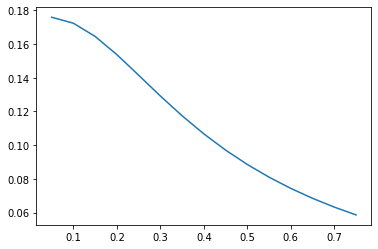

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0.05,0.8,0.05),cs)

In [ ]:
cs

[0.17589123493787234,
 0.17234847405142473,
 0.1645016607990827,
 0.15370570811962073,
 0.1415131114516531,
 0.1291661543590986,
 0.11743747447191714,
 0.10670312636670776,
 0.09708070986758453,
 0.0885460548351353,
 0.08100924227276131,
 0.07435755708035713,
 0.06847729270745755,
 0.06326355685773659,
 0.05862378279684705]